In [1]:
import os
import math
import sys
import glob
import pickle
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tqdm.notebook import tqdm

In [295]:
kind = 'all-cols-with-time'
region = 'fall'

In [296]:
variant = 'sine 750 mv'
pred_dir = os.path.join('predictions',variant,region)
metrics_dir = 'metrics'
rst_graph = os.path.join('graphs','outputs',variant,region)
metrics_graph = os.path.join('graphs','metrics',variant,region)

In [297]:
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)
if not os.path.exists(metrics_dir):
    os.makedirs(metrics_dir)
if not os.path.exists(metrics_graph):
    os.makedirs(metrics_graph)
if not os.path.exists(rst_graph):
    os.makedirs(rst_graph)

In [298]:
metric_file ='rf_inc_{}-{}-{}.csv'.format(region, variant, kind)

In [299]:
train_loc = "D:\\Final Year Project\\Play with DWT\\Sine\\dataset\\{}\\segmented\\train\\{}".format(variant, region)
test_loc = "D:\\Final Year Project\\Play with DWT\\Sine\\dataset\\{}\\segmented\\test\\{}".format(variant, region)

In [300]:
train_files = glob.glob(train_loc + "\\*.csv")
test_files = glob.glob(test_loc + "\\*.csv")

In [301]:
inputs = ['Unnamed: 0', 'vdd','xpd','vinp','vinn','temperature','process']

train_files = glob.glob(os.path.join(train_loc, "*.csv"))
test_files = glob.glob(os.path.join(test_loc, "*.csv"))

columns = ['Unnamed: 0', 'vdd', 'xpd', 'vinp', 'vinn', 'temperature', 'process']

dfs = list()
for fpath in train_files:
    df = pd.read_csv(fpath, usecols = columns)
    dfs.append(df)
df_train = pd.concat(dfs, ignore_index=True)

In [302]:
df_train 

,Unnamed: 0,vdd,xpd,vinp,vinn,temperature,process
0,13000,3.3,3.300,1.650000,1.587832,-15,fastnfastp
1,13001,3.3,3.267,1.652355,1.590263,-15,fastnfastp
2,13002,3.3,3.234,1.654709,1.592694,-15,fastnfastp
3,13003,3.3,3.201,1.657064,1.595124,-15,fastnfastp
4,13004,3.3,3.168,1.659419,1.597555,-15,fastnfastp
...,...,...,...,...,...,...,...
279995,14995,3.0,0.000,1.638227,0.883872,85,typical
279996,14996,3.0,0.000,1.640581,0.883918,85,typical
279997,14997,3.0,0.000,1.642936,0.883964,85,typical
279998,14998,3.0,0.000,1.645291,0.884009,85,typical


In [303]:
# df_list = (pd.read_csv(file) for file in train_files)

# # Concatenate all DataFrames
# df   = pd.concat(df_list, ignore_index=True)

# df
df = df_train

In [304]:
df.describe(),df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280000 entries, 0 to 279999
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   280000 non-null  int64  
 1   vdd          280000 non-null  float64
 2   xpd          280000 non-null  float64
 3   vinp         280000 non-null  float64
 4   vinn         280000 non-null  float64
 5   temperature  280000 non-null  int64  
 6   process      280000 non-null  object 
dtypes: float64(4), int64(2), object(1)
memory usage: 15.0+ MB


(          Unnamed: 0            vdd            xpd           vinp  \
 count  280000.000000  280000.000000  280000.000000  280000.000000   
 mean    13999.500000       3.289286       0.083054       1.650000   
 std       577.351228       0.246894       0.420917       0.265079   
 min     13000.000000       3.000000       0.000000       1.275000   
 25%     13499.750000       3.000000       0.000000       1.384966   
 50%     13999.500000       3.300000       0.000000       1.650000   
 75%     14499.250000       3.600000       0.000000       1.915034   
 max     14999.000000       3.600000       3.600000       2.025000   
 
                 vinn    temperature  
 count  280000.000000  280000.000000  
 mean        0.917853      34.285714  
 std         0.286002      59.397591  
 min         0.333386     -55.000000  
 25%         0.745279     -15.000000  
 50%         0.893574      25.000000  
 75%         1.181353      85.000000  
 max         1.966319     125.000000  ,
 None)

In [305]:
df.rename(columns = {'Unnamed: 0':'itime'}, inplace = True)
df

,itime,vdd,xpd,vinp,vinn,temperature,process
0,13000,3.3,3.300,1.650000,1.587832,-15,fastnfastp
1,13001,3.3,3.267,1.652355,1.590263,-15,fastnfastp
2,13002,3.3,3.234,1.654709,1.592694,-15,fastnfastp
3,13003,3.3,3.201,1.657064,1.595124,-15,fastnfastp
4,13004,3.3,3.168,1.659419,1.597555,-15,fastnfastp
...,...,...,...,...,...,...,...
279995,14995,3.0,0.000,1.638227,0.883872,85,typical
279996,14996,3.0,0.000,1.640581,0.883918,85,typical
279997,14997,3.0,0.000,1.642936,0.883964,85,typical
279998,14998,3.0,0.000,1.645291,0.884009,85,typical


In [306]:
print (df.columns,'\n')
print (df.head())

Index(['itime', 'vdd', 'xpd', 'vinp', 'vinn', 'temperature', 'process'], dtype='object') 

   itime  vdd    xpd      vinp      vinn  temperature     process
0  13000  3.3  3.300  1.650000  1.587832          -15  fastnfastp
1  13001  3.3  3.267  1.652355  1.590263          -15  fastnfastp
2  13002  3.3  3.234  1.654709  1.592694          -15  fastnfastp
3  13003  3.3  3.201  1.657064  1.595124          -15  fastnfastp
4  13004  3.3  3.168  1.659419  1.597555          -15  fastnfastp


In [307]:
X = df[['itime', 'vdd', 'xpd', 'vinp', 'process', 'temperature']]
Y = df[['vinn']]

In [308]:
numeric_columns=list(X[['itime', 'vdd', 'xpd', 'vinp']])
categorical_columns=list(X.select_dtypes('object').columns)

num_col= X[numeric_columns]
cat_col = X[categorical_columns]

scaler = StandardScaler()
# num = pd.DataFrame(scaler.fit_transform(num_col))
num = num_col

encoder = OneHotEncoder(categories=[['fastnfastp','slownfastp','typical','fastnslowp', 'slownslowp']])
cat = pd.DataFrame(encoder.fit_transform(cat_col).toarray())

In [309]:
num

,itime,vdd,xpd,vinp
0,13000,3.3,3.300,1.650000
1,13001,3.3,3.267,1.652355
2,13002,3.3,3.234,1.654709
3,13003,3.3,3.201,1.657064
4,13004,3.3,3.168,1.659419
...,...,...,...,...
279995,14995,3.0,0.000,1.638227
279996,14996,3.0,0.000,1.640581
279997,14997,3.0,0.000,1.642936
279998,14998,3.0,0.000,1.645291


In [310]:
type(cat_col)

pandas.core.frame.DataFrame

In [311]:
cat

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
279995,0.0,0.0,1.0,0.0,0.0
279996,0.0,0.0,1.0,0.0,0.0
279997,0.0,0.0,1.0,0.0,0.0
279998,0.0,0.0,1.0,0.0,0.0


In [312]:
X_train = pd.concat([num, df[['temperature']], cat], axis = 1)

X_train.columns = ['itime', 'vdd', 'xpd', 'vinp', 'temperature', 'process_0', 'process_1', 'process_2', 'process_3', 'process_4']
X_train

,itime,vdd,xpd,vinp,temperature,process_0,process_1,process_2,process_3,process_4
0,13000,3.3,3.300,1.650000,-15,1.0,0.0,0.0,0.0,0.0
1,13001,3.3,3.267,1.652355,-15,1.0,0.0,0.0,0.0,0.0
2,13002,3.3,3.234,1.654709,-15,1.0,0.0,0.0,0.0,0.0
3,13003,3.3,3.201,1.657064,-15,1.0,0.0,0.0,0.0,0.0
4,13004,3.3,3.168,1.659419,-15,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
279995,14995,3.0,0.000,1.638227,85,0.0,0.0,1.0,0.0,0.0
279996,14996,3.0,0.000,1.640581,85,0.0,0.0,1.0,0.0,0.0
279997,14997,3.0,0.000,1.642936,85,0.0,0.0,1.0,0.0,0.0
279998,14998,3.0,0.000,1.645291,85,0.0,0.0,1.0,0.0,0.0


In [313]:
Y_train = Y
Y_train

,vinn
0,1.587832
1,1.590263
2,1.592694
3,1.595124
4,1.597555
...,...
279995,0.883872
279996,0.883918
279997,0.883964
279998,0.884009


In [314]:
# # rf = RandomForestRegressor(n_estimators = 10, max_depth=10, random_state = 42)
# # rf.fit(X_train, Y_train)

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'max_features': ['sqrt', 'log2'],
#     'random_state': [42]
# }

# rf = RandomForestRegressor()
# grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, verbose=2)
# grid_search.fit(X_train, Y_train)

# best_params = grid_search.best_params_
# print(best_params)

In [315]:
# print(best_params)

In [316]:
rf = RandomForestRegressor(
    n_estimators = 100, 
    max_depth=10, 
    max_features='sqrt',
    min_samples_split=10,
    random_state = 42)
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10,
                      random_state=42)

In [317]:
model_name = "RF_BATCH_ALLCOLS_{}_{}_{}_model.pkl".format(region, variant, kind)
pickle.dump(rf, open(model_name,'wb'))
print(model_name)
print("model saved")

RF_BATCH_ALLCOLS_fall_sine 750 mv_all-cols-with-time_model.pkl
model saved


In [318]:
def SNR(y, y_pred):
    n = len(y)
    upper = 0
    lower = 0
    for ind in range(0,n):
        out = y.iloc[ind]
        pred_out = y_pred.iloc[ind]
        upper += (out ** 2)
        lower += (out - pred_out) ** 2
        
    snr = 10 * math.log10(upper / lower)
    return snr

In [319]:
test_files = glob.glob(test_loc + '/*.csv')

In [320]:
def predict(file,enc,m1):
    df_test = pd.read_csv(file, usecols=columns)
    df_test.rename(columns = {'Unnamed: 0':'itime'}, inplace = True)
    
    y_test = df_test['vinn']
    X = df_test.drop(["vinn"],axis=1)
    
    numeric_columns=list(X[['itime', 'vdd', 'xpd', 'vinp']])
    categorical_columns=list(X[['process']])
    time = df_test['itime']

    num_col= X[numeric_columns]
    cat_col = X[categorical_columns]
    cat_col = pd.DataFrame(cat_col)

    num = num_col

    cat = pd.DataFrame(encoder.transform(cat_col).toarray())
    
    x_test = pd.concat([num, df_test[['temperature']], cat], axis = 1)
    x_test.columns = ['itime', 'vdd', 'xpd', 'vinp', 'temperature', 'process_0', 'process_1', 'process_2', 'process_3', 'process_4']
    
    y_pred = rf.predict(x_test)
    # y_pred_adf = [adf.predict_one(x) for i,x in tqdm(enumerate(x_test)) ]
    # y_pred_oxt = [oxt.predict_one(x) for i,x in tqdm(enumerate(x_test)) ]
    
    p1 = pd.Series(y_pred)
    # p2 = pd.Series(y_pred_adf)
    # p3 = pd.Series(y_pred_oxt)
    
    mae1 = mean_absolute_error(y_test, p1)
    # mae2 = mean_absolute_error(y_test, p2)
    # mae3 = mean_absolute_error(y_test, p3)

    mse1 = mean_squared_error(y_test, p1)
    # mse2 = mean_squared_error(y_test, p2)
    # mse3 = mean_squared_error(y_test, p3)

    r2_1 = r2_score(y_test, p1)
    # r2_2 = r2_score(y_test, p2)
    # r2_3 = r2_score(y_test, p3)

    snr1 = SNR(y_test,p1)
    # snr2 = SNR(y_test,p2)
    # snr3 = SNR(y_test,p3)

    rmse1 = math.sqrt(mse1)
    # rmse2 = math.sqrt(mse2)
    # rmse3 = math.sqrt(mse3)
    
    df_result_srp = pd.DataFrame()
    # df_result_adf = pd.DataFrame()
    # df_result_oxt = pd.DataFrame()

    df_result_srp["Time"] = time
    # df_result_adf["Time"] = time
    # df_result_oxt["Time"] = time

    df_result_srp["actual vinn"] = y_test
    # df_result_adf["actual vinn"] = y_test
    # df_result_oxt["actual vinn"] = y_test

    df_result_srp["predicted vinn"] = p1
    # df_result_adf["predicted vinn"] = p2
    # df_result_oxt["predicted vinn"] = p3
    
    file_name = os.path.basename(file)

#     df_result_srp.to_csv(('./Incremental/RandomForest/Hoeffeding_trees/predictions_bg-seed/' +  file_name),index = False )
    df_result_srp.to_csv(pred_dir + '//' + file_name, index = False )
    # df_result.to_csv(('./predictions_adf/' +  file_name),index = False )
    # df_result_oxt.to_csv(('./predictions_oxt/' +  file_name),index = False )
    

    metrics_1 = {'file_name' : file_name, 'RMSE':round(rmse1,4), 'MSE': round(mse1,4), 'MAE':round(mae1,4), 'R2':round(r2_1,4), 'SNR':round(snr1,4)}
    # metrics_2 = {'file_name' : file_name,'RMSE':round(rmse2,4), 'MSE': round(mse2,4), 'MAE':round(mae2,4), 'R2':round(r2_2,4), 'SNR':round(snr2,4)}
    # metrics_3 = {'file_name' : file_name,'RMSE':round(rmse3,4), 'MSE': round(mse3,4), 'MAE':round(mae3,4), 'R2':round(r2_3,4), 'SNR':round(snr3,4)}
    
    m1 = m1.append(metrics_1, ignore_index = True)
    # m2 = m2.append(metrics_2, ignore_index = True)
    # m3 = m3.append(metrics_3, ignore_index = True)
    
    return m1

In [321]:
i = 1

metrics_df = pd.DataFrame()

for file in test_files:
    print("File : ",i)
    metrics_df = predict(file,encoder,metrics_df)
    print('-----------')
    i = i+1
# metrics_df.to_csv('srp regressor.csv', index = False )
# metrics['SNR'].avg()



File :  1
-----------
File :  2
-----------
File :  3
-----------
File :  4
-----------
File :  5
-----------
File :  6
-----------
File :  7
-----------
File :  8
-----------
File :  9
-----------
File :  10
-----------


In [322]:
metrics_df.to_csv(os.path.join(metrics_dir, metric_file), index = False)
metrics_df

,file_name,RMSE,MSE,MAE,R2,SNR
0,fastnfastp_3.3V_45.csv,0.0057,0.0000,0.0046,0.9909,46.4882
1,fastnfastp_3.6V_45.csv,0.0093,0.0001,0.0083,0.9783,42.3421
2,fastnslowp_3.3V_45.csv,0.0204,0.0004,0.0201,0.6240,35.3803
3,fastnslowp_3.6V_45.csv,0.0141,0.0002,0.0137,0.8165,38.8796
4,slownfastp_3.3V_45.csv,0.0408,0.0017,0.0405,0.9141,21.9524
5,slownfastp_3.6V_45.csv,0.0467,0.0022,0.0464,0.8933,19.9172
6,slownslowp_3.3V_45.csv,0.0086,0.0001,0.0084,0.9931,39.0028
7,slownslowp_3.6V_45.csv,0.0208,0.0004,0.0206,0.9629,31.2344
8,typical_3.3V_45.csv,0.0023,0.0000,0.0016,0.9993,51.7495
9,typical_3.6V_45.csv,0.0033,0.0000,0.0022,0.9987,48.7742


In [323]:
# Before executing this cell zip graphs_bag and download
def draw (file,name):
    df_fun=pd.read_csv(file)
    
    X_time=df_fun['Time']
    vinn = df_fun['actual vinn']
    pred_vinn = df_fun['predicted vinn']
    
    fig=plt.figure(figsize=(16,9), facecolor='w', edgecolor='k')
    plt.plot(X_time,vinn, color="red", linewidth=3, label = vinn)
    plt.plot(X_time,pred_vinn, color="blue", linewidth=3, label = pred_vinn)
    
    temp_values = {
        '-55':'-55T',
        '-35':'-35T',
        '-15':'-15T',
        '5':'5T',
        '25':'25T',
        '45':'45T',
        '65':'65T',
        '85':'85T',
        '105':'105T',
        '125':'125T',
    }
    
#     tokens = name.split('_')
#     temp = temp_values[tokens[-1][:-4]]
#     title =  "_".join(tokens[:-1] + [temp])
    title = name
    
    plt.xlabel("Time(ns)", fontsize=15)
    plt.ylabel("vinn", fontsize=15)
    plt.grid(True)
    plt.legend()
    plt.legend(["Actual vinn", "Predicted vinn"], loc ="lower right")
    plt.title(title)
    

    nm = rst_graph + '//' + title + ".jpg"
    plt.savefig(nm)

File  1
---------------
File  2
---------------
File  3
---------------
File  4
---------------
File  5
---------------
File  6
---------------
File  7
---------------
File  8
---------------
File  9
---------------
File  10
---------------


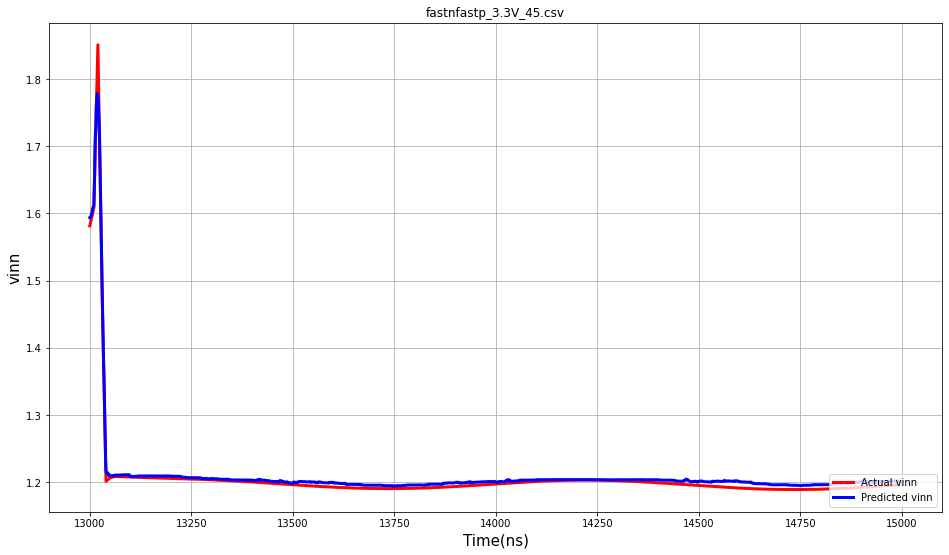

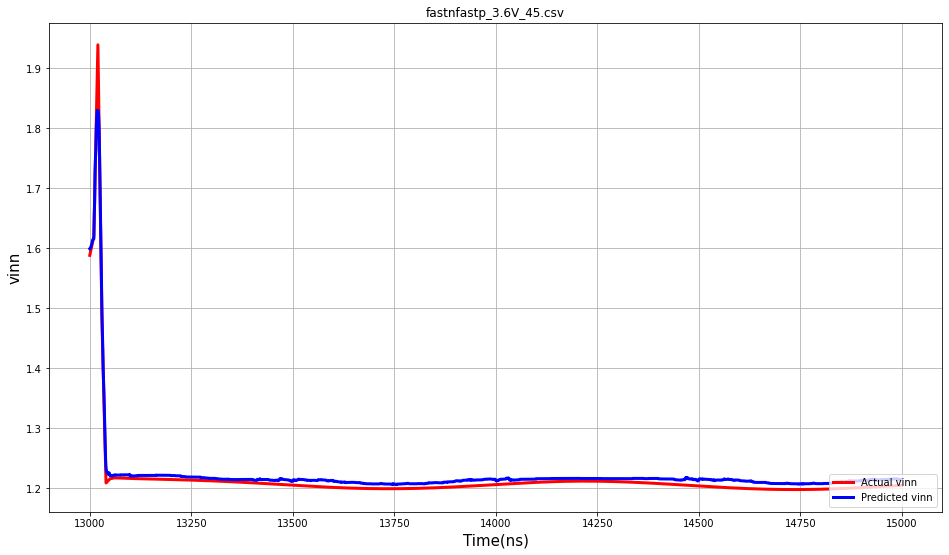

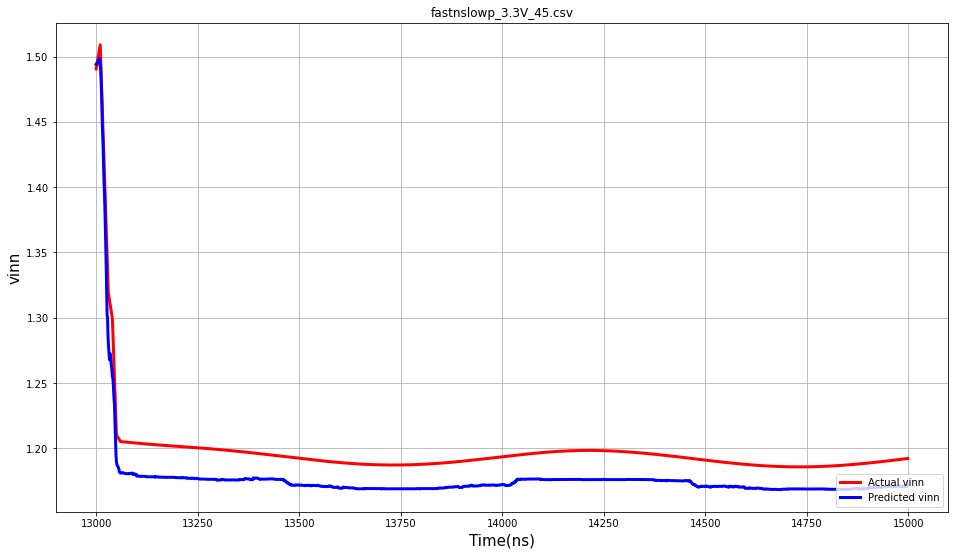

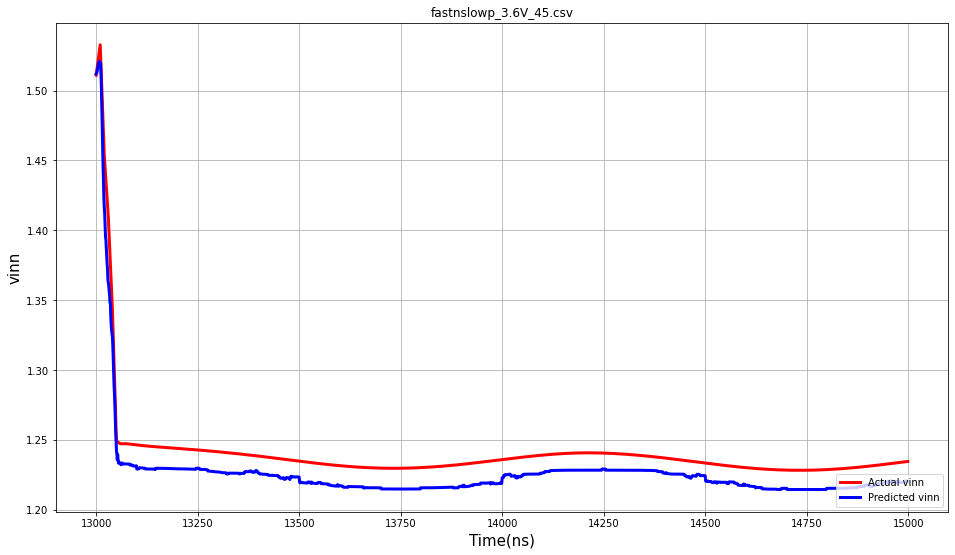

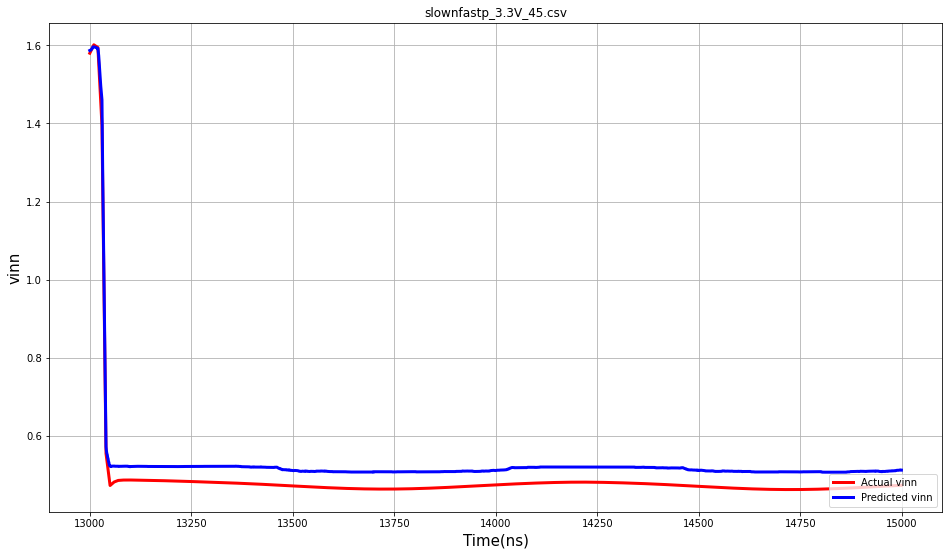

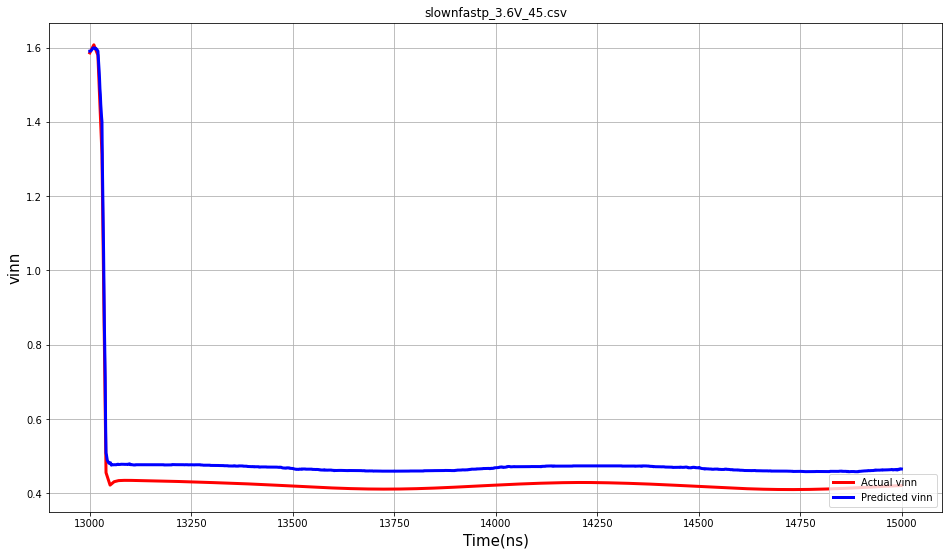

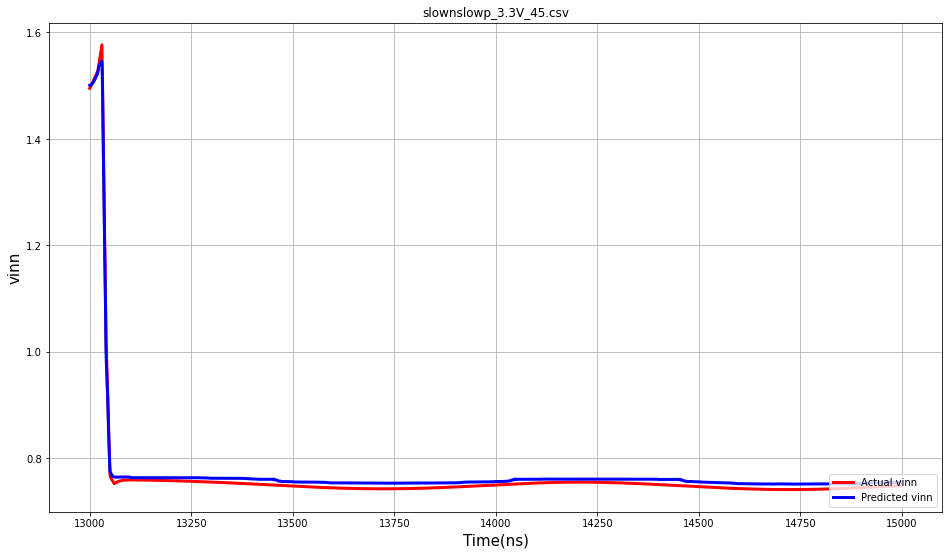

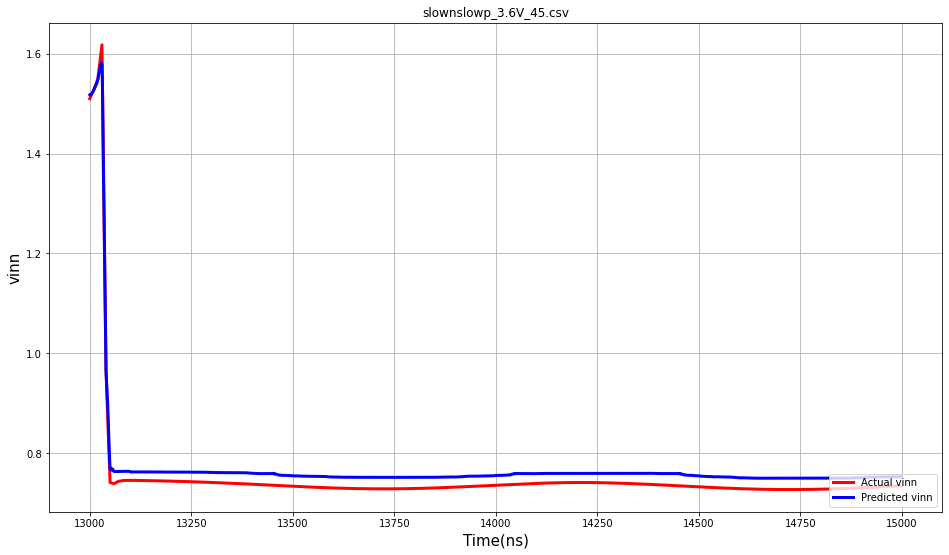

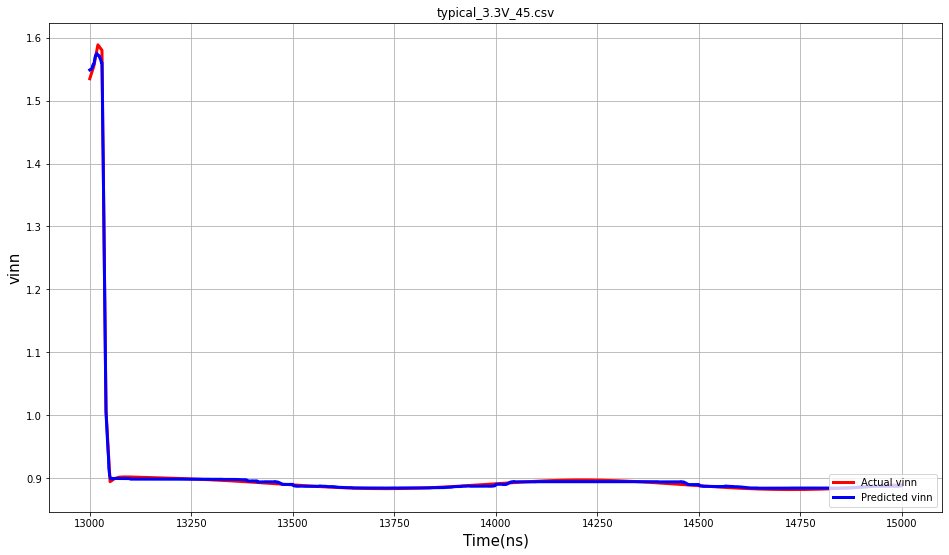

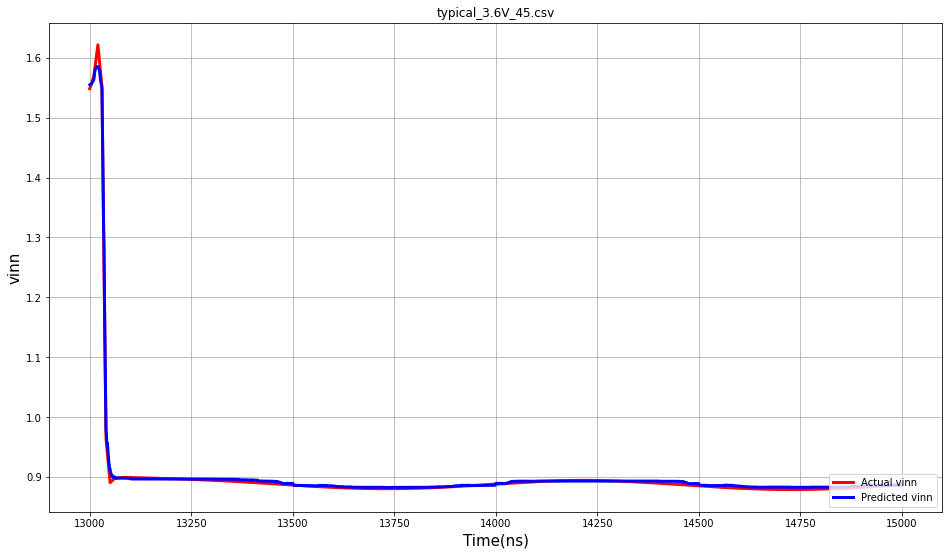

In [324]:
path = pred_dir + '//' + "*.csv"
count =0
for file in glob.glob(path):
    count = count+1
    print ("File ", count)
    print ("---------------")
    name = os.path.basename(file)
    draw(file,name)